In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
from collections import defaultdict
from itertools import combinations
from scipy.sparse import coo_matrix

from qiskit import transpile, QuantumCircuit
# from qiskit.primitives import Estimator, Sampler
from qiskit.primitives import BackendSampler
from qiskit.quantum_info import hellinger_fidelity, SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.result import sampled_expectation_value
from qiskit_aer import AerSimulator

from cd_coefficients import eval_A, eval_B, eval_C, eval_D, first_order_cd_coeff
from scheduling_function import f, df
from bias_field import eval_hb, gs_rotation_angle
from dcqo import dcqo_circ, bf_dcqo_circ

In [2]:
warnings.filterwarnings('ignore')

## Maximum independent set (MIS) problem for heavy-hex graph
### QUBO
Let $x_i = 1$ if vertex $i$ is in the independent set, and $x_i = 0$ otherwise. 
The QUBO for the MIS problem of a graph $G = (V, E)$ is therefore:
$$\mathrm{Minimize:} -\sum_{I \in V} x_i + 2 \sum_{(i, j) \in E} x_i x_j$$

### Ising Hamiltonian of MIS problem
Let $z_i \in \{-1, 1 \}$ where 
$$x_i = \frac{1 - z_i}{2}$$
Then
$$\mathrm{Minimize:} - \frac{1}{2} \sum_{I \in V} (1 - z_i) + \frac{1}{2} \sum_{(i, j) \in E} (1 - z_i) (1 - z_j) = \frac{1}{2} \sum_{I \in V} z_i + \frac{1}{2} \sum_{(i, j) \in E} (- z_i - z_j + z_i z_j) + \frac{- |V| + |E|}{2}$$
The Hamiltonian is:
$$H_C = \frac{1}{2} \sum_{I \in V} Z_i + \frac{1}{2} \sum_{(i, j) \in E} (- Z_i - Z_j + Z_i Z_j)$$

In [3]:
# Heavy-hex 21Q Ising model
# 1st layer
edges_1 = [(0, 9), (1, 2), (4, 5), (6, 7), (10, 16), (14, 15), (17, 18), (19, 20)]

# 2nd layer
edges_2 = [(2, 3), (4, 10), (5, 6), (8, 11), (9, 12), (13, 14), (15, 16)]

# 3rd layer
edges_3 = [(0, 1), (3, 4), (7, 8), (11, 20), (12, 13), (16, 17), (18, 19)]

edges = edges_1 + edges_2 + edges_3

num_nodes = 21
num_edges = len(edges)
print(num_edges)

22


In [4]:
# Hi
hx = - np.ones(num_nodes)
hb = np.zeros(num_nodes)

# Hf
hz = 0.5 * np.ones(num_nodes)
for i, j in edges:
    hz[i] -= 0.5
    hz[j] -= 0.5

row = np.array([e[0] for e in edges])
col = np.array([e[1] for e in edges])
data = 0.5 * np.ones(num_edges)

J = coo_matrix((data, (row, col)), shape=(num_nodes, num_nodes))
J2 = coo_matrix((data ** 2, (row, col)), shape=(num_nodes, num_nodes))
J4 = coo_matrix((data ** 4, (row, col)), shape=(num_nodes, num_nodes))

## Adiabatic and counterdiabatic terms of Ising model Hamiltonian without bias field
$$H_{ad} = (1 - \lambda) \sum_i h^x_i X_i + \mathcal{O}(\lambda)$$
$$H_{cd} = - 2 \dot{\lambda} \alpha_1 \left[ \sum_i h^z_i Y_i + \sum_{i < j} J_{ij} (Y_i Z_j + Z_i Y_j) \right]$$

## Adiabatic and counterdiabatic terms of Ising model Hamiltonian with bias field
$$H_{ad} = (1 - \lambda) \sum_i (h^x_i X_i - h^b_i Z_i) + \mathcal{O}(\lambda)$$
$$H_{cd} = - 2 \dot{\lambda} \alpha_1 \left[ \sum_i h^z_i Y_i + \sum_{i < j} J_{ij} (Y_i Z_j + Z_i Y_j) \right]$$

In [5]:
T = 1
A = eval_A(hx, hz, J2)
B = eval_B(hx, hz, J2, hb=None)
C = eval_C(hx, hz, J2, hb=None)
D = eval_D(hx, hz, J2, J4)

N = 100
x = [T * ti / N for ti in range(N + 1)]
y = [f(xi, T) for xi in x]
z = [df(xi, T) for xi in x]
a1 = [first_order_cd_coeff(A, B, C, D, yi) for yi in y]
w = [2 * abs(v) * w for v, w in zip(a1, z)]

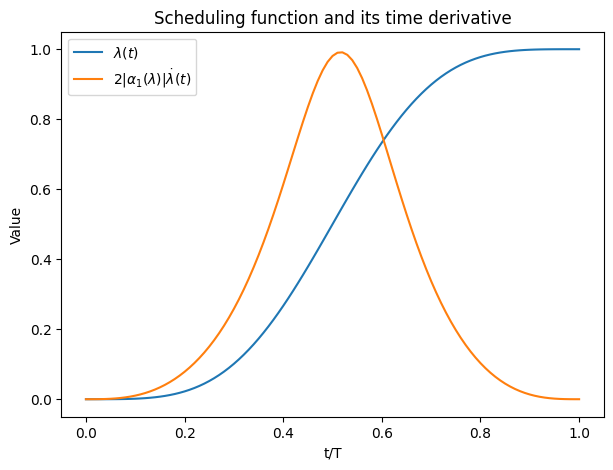

In [6]:
plt.figure(figsize=(7, 5))
plt.plot(x, y)
plt.plot(x, w)

# plt.xticks(rotation=90)
plt.xlabel("t/T")
plt.ylabel("Value")
plt.title("Scheduling function and its time derivative")
plt.legend([r"$\lambda (t)$", r"$2 |\alpha_1 (\lambda)| \dot{\lambda} (t)$"])
plt.show()

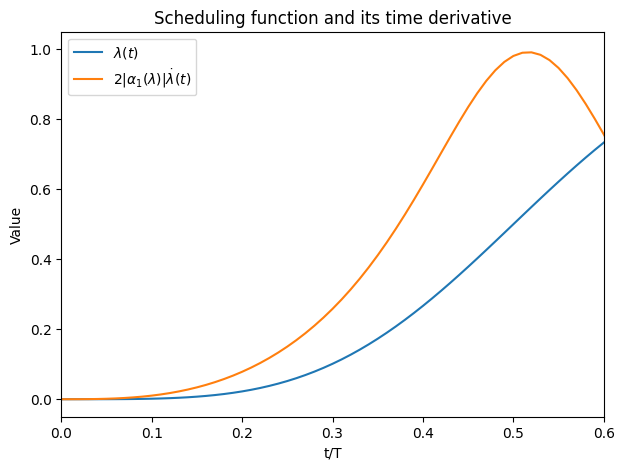

In [6]:
plt.figure(figsize=(7, 5))

plt.plot(x, y)
plt.plot(x, w)

# plt.xticks(rotation=90)
plt.xlabel("t/T")
plt.ylabel("Value")
plt.xlim(0.0, 0.6)
# plt.ylim(0.0, 0.6)
plt.title("Scheduling function and its time derivative")
plt.legend([r"$\lambda (t)$", r"$2 |\alpha_1 (\lambda)| \dot{\lambda} (t)$"])
plt.show()

In [7]:
# threshold for gate cutoff
# threshold = 0.10
shots = 2 ** 13

# MPS simulator
backend = AerSimulator(method="matrix_product_state")
sampler = BackendSampler(backend, options={"shots": shots})

## Ising Hamiltonian

In [8]:
pauli_list = []

for i, d in enumerate(hz):
    pauli_list.append(("Z", [i], d))

for i, j, d in zip(row, col, data):
    pauli_list.append(("ZZ", [i, j], d))

# via triples and local Paulis with indices
print(pauli_list)
Hf = SparsePauliOp.from_sparse_list(pauli_list, num_qubits=num_nodes)
# print(Hf)

[('Z', [0], -0.5), ('Z', [1], -0.5), ('Z', [2], -0.5), ('Z', [3], -0.5), ('Z', [4], -1.0), ('Z', [5], -0.5), ('Z', [6], -0.5), ('Z', [7], -0.5), ('Z', [8], -0.5), ('Z', [9], -0.5), ('Z', [10], -0.5), ('Z', [11], -0.5), ('Z', [12], -0.5), ('Z', [13], -0.5), ('Z', [14], -0.5), ('Z', [15], -0.5), ('Z', [16], -1.0), ('Z', [17], -0.5), ('Z', [18], -0.5), ('Z', [19], -0.5), ('Z', [20], -0.5), ('ZZ', [0, 9], 0.5), ('ZZ', [1, 2], 0.5), ('ZZ', [4, 5], 0.5), ('ZZ', [6, 7], 0.5), ('ZZ', [10, 16], 0.5), ('ZZ', [14, 15], 0.5), ('ZZ', [17, 18], 0.5), ('ZZ', [19, 20], 0.5), ('ZZ', [2, 3], 0.5), ('ZZ', [4, 10], 0.5), ('ZZ', [5, 6], 0.5), ('ZZ', [8, 11], 0.5), ('ZZ', [9, 12], 0.5), ('ZZ', [13, 14], 0.5), ('ZZ', [15, 16], 0.5), ('ZZ', [0, 1], 0.5), ('ZZ', [3, 4], 0.5), ('ZZ', [7, 8], 0.5), ('ZZ', [11, 20], 0.5), ('ZZ', [12, 13], 0.5), ('ZZ', [16, 17], 0.5), ('ZZ', [18, 19], 0.5)]


## Counterdiabatic evolution without bias field

In [9]:
T = 1
dt = 0.1
trotter_steps = [1, 2, 3, 4, 5]

A = eval_A(hx, hz, J2)
B = eval_B(hx, hz, J2, hb=None)
C = eval_C(hx, hz, J2, hb=None)
D = eval_D(hx, hz, J2, J4)

y = [f(ti * dt, T) for ti in trotter_steps]
dy = [df(ti * dt, T) for ti in trotter_steps]
a1 = [first_order_cd_coeff(A, B, C, D, yi) for yi in y]

print(y)
print(dy)
print(a1)
print([2 * abs(v) * w for v, w in zip(a1, dy)])

[0.0014769153294477333, 0.022331076294855843, 0.10120449450040796, 0.2667176834867113, 0.4999999999999998]
[0.058561065202698374, 0.42858717205073044, 1.20408664729688, 2.0755709636919755, 2.4674011002723395]
[-0.08769712946957511, -0.0914421787330339, -0.10720537621274481, -0.1477605499086514, -0.198740377886634]
[0.01027127463391454, 0.07838188957869688, 0.2581691240324092, 0.6133750139391116, 0.9807444541320426]


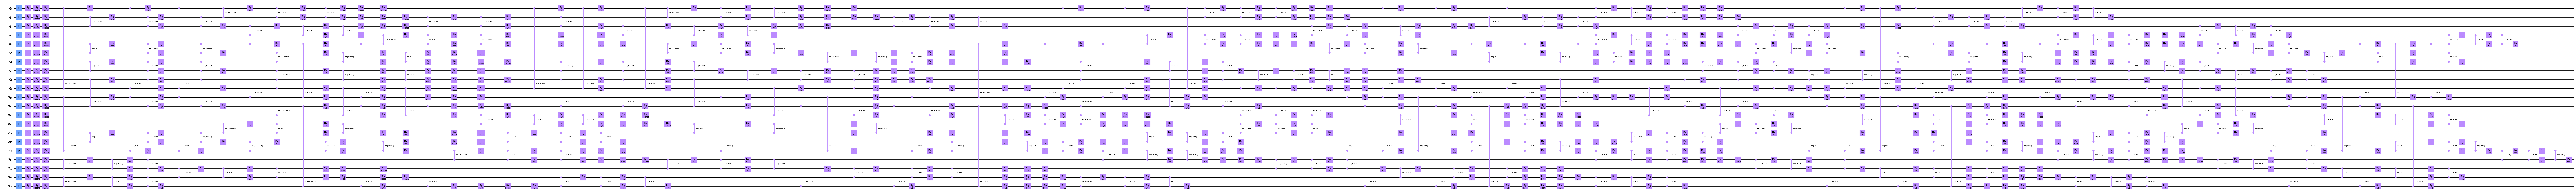

In [10]:
circ = dcqo_circ(num_nodes, hx, hz, row, col, data, y, dy, a1, add_measurement=False)
circ.draw("mpl", fold=-1)

In [11]:
circ = dcqo_circ(num_nodes, hx, hz, row, col, data, y, dy, a1)
job = sampler.run(circuits=[circ], shots=shots)
job_result = job.result()
pdist_0 = job_result.quasi_dists[0].binary_probabilities()
# print(pdist_0)

In [12]:
objective_0 = []
for k, p in pdist_0.items():
    v = sampled_expectation_value({k: 1.0}, Hf)
    objective_0.append(v)

print(min(objective_0))

-11.5


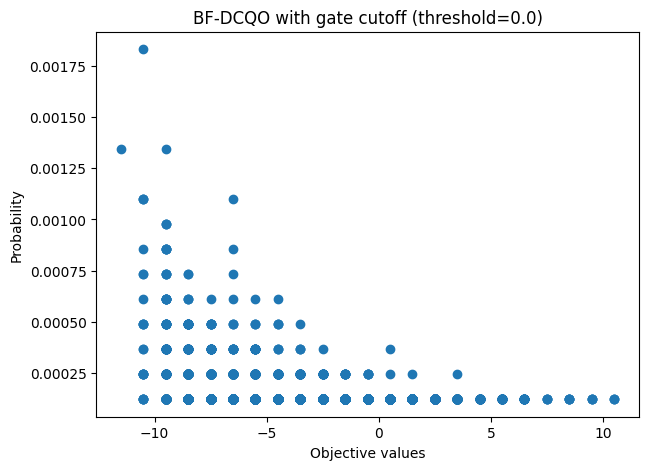

In [14]:
plt.figure(figsize=(7, 5))

plt.scatter(objective_0, pdist_0.values())

# plt.xticks(rotation=90)
plt.xlabel("Objective values")
plt.ylabel("Probability")
plt.title("BF-DCQO with gate cutoff (threshold=0.0)")
plt.show()

In [18]:
print(circ.count_ops())
isa_circ = transpile(circ, basis_gates=["rz", "sx", "cz"], optimization_level=3)
print(isa_circ.count_ops())

OrderedDict([('rx', 545), ('rzz', 330), ('rz', 105), ('ry', 105), ('h', 21), ('measure', 21), ('barrier', 1)])
OrderedDict([('rz', 946), ('sx', 922), ('cz', 220), ('measure', 21), ('barrier', 1)])


In [24]:
T = 1
dt = 0.083
trotter_steps = [1, 2, 3, 4, 5, 6]

A = eval_A(hx, hz, J2)
B = eval_B(hx, hz, J2, hb=None)
C = eval_C(hx, hz, J2, hb=None)
D = eval_D(hx, hz, J2, J4)

y = [f(ti * dt, T) for ti in trotter_steps]
dy = [df(ti * dt, T) for ti in trotter_steps]
a1 = [first_order_cd_coeff(A, B, C, D, yi) for yi in y]

print(y)
print(dy)
print(a1)
print([2 * abs(v) * w for v, w in zip(a1, dy)])

[0.0007047018215946171, 0.01086032194292445, 0.05121978911700298, 0.14444016364218507, 0.29863804148092976, 0.4950653103828826]
[0.03376095537876456, 0.2548065866572011, 0.7668100252011657, 1.4986981664353747, 2.1784194342589362, 2.4672322271668166]
[-0.08756175697994359, -0.0893608503489302, -0.09691933081513819, -0.1169220172896768, -0.15623049590944874, -0.1981872497350986]
[0.005912337140572203, 0.045539466516391715, 0.14863742900967247, 0.3504616258559276, 0.6806710970261087, 0.9779479391199868]


In [25]:
circ = dcqo_circ(num_nodes, hx, hz, row, col, data, y, dy, a1)
job = sampler.run(circuits=[circ], shots=shots)
job_result = job.result()
pdist_0 = job_result.quasi_dists[0].binary_probabilities()
# print(pdist_0)

In [26]:
objective_0 = []
for k, p in pdist_0.items():
    v = sampled_expectation_value({k: 1.0}, Hf)
    objective_0.append(v)

print(min(objective_0))

-11.5


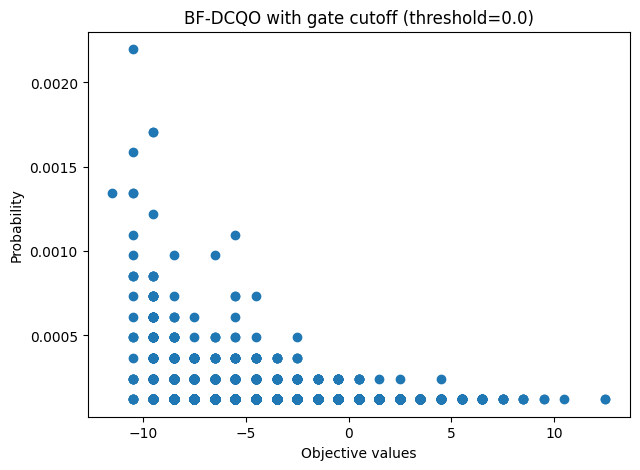

In [27]:
plt.figure(figsize=(7, 5))

plt.scatter(objective_0, pdist_0.values())

# plt.xticks(rotation=90)
plt.xlabel("Objective values")
plt.ylabel("Probability")
plt.title("BF-DCQO with gate cutoff (threshold=0.0)")
plt.show()

In [28]:
print(circ.count_ops())
isa_circ = transpile(circ, basis_gates=["rz", "sx", "cz"], optimization_level=3)
print(isa_circ.count_ops())

OrderedDict([('rx', 654), ('rzz', 396), ('rz', 126), ('ry', 126), ('h', 21), ('measure', 21), ('barrier', 1)])
OrderedDict([('rz', 1120), ('sx', 1098), ('cz', 264), ('measure', 21), ('barrier', 1)])


In [29]:
T = 1
dt = 0.072
trotter_steps = [1, 2, 3, 4, 5, 6, 7]

A = eval_A(hx, hz, J2)
B = eval_B(hx, hz, J2, hb=None)
C = eval_C(hx, hz, J2, hb=None)
D = eval_D(hx, hz, J2, J4)

y = [f(ti * dt, T) for ti in trotter_steps]
dy = [df(ti * dt, T) for ti in trotter_steps]
a1 = [first_order_cd_coeff(A, B, C, D, yi) for yi in y]

print(y)
print(dy)
print(a1)
print([2 * abs(v) * w for v, w in zip(a1, dy)])

[0.0004002085356881362, 0.0062291179811567714, 0.029970083106401146, 0.0874069419734793, 0.18997260088648996, 0.3365507078373636, 0.5098687037825237]
[0.0221359751352888, 0.16971593983513378, 0.5281441081926853, 1.095880450630171, 1.7515827730118303, 2.278833549660478, 2.4667256689159482]
[-0.08750844223036415, -0.08853537251352399, -0.09285753917277896, -0.10426324349812384, -0.12791490158912375, -0.16615987670799984, -0.1997384973233004]
[0.0038741694026783943, 0.03005172790957279, 0.09808432443074937, 0.22852010053777438, 0.4481070760700255, 0.7573014032992773, 0.985400156836169]


In [30]:
circ = dcqo_circ(num_nodes, hx, hz, row, col, data, y, dy, a1)
job = sampler.run(circuits=[circ], shots=shots)
job_result = job.result()
pdist_0 = job_result.quasi_dists[0].binary_probabilities()
# print(pdist_0)

In [31]:
objective_0 = []
for k, p in pdist_0.items():
    v = sampled_expectation_value({k: 1.0}, Hf)
    objective_0.append(v)

print(min(objective_0))

-11.5


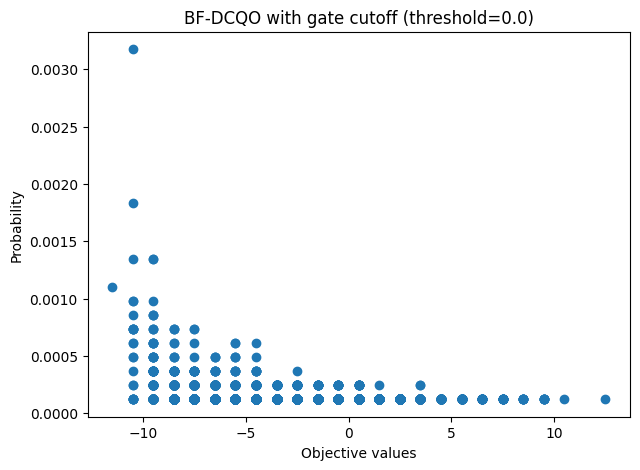

In [32]:
plt.figure(figsize=(7, 5))

plt.scatter(objective_0, pdist_0.values())

# plt.xticks(rotation=90)
plt.xlabel("Objective values")
plt.ylabel("Probability")
plt.title("BF-DCQO with gate cutoff (threshold=0.0)")
plt.show()

In [33]:
print(circ.count_ops())
isa_circ = transpile(circ, basis_gates=["rz", "sx", "cz"], optimization_level=3)
print(isa_circ.count_ops())

OrderedDict([('rx', 763), ('rzz', 462), ('rz', 147), ('ry', 147), ('h', 21), ('measure', 21), ('barrier', 1)])
OrderedDict([('rz', 1299), ('sx', 1274), ('cz', 308), ('measure', 21), ('barrier', 1)])
